# Outline:
* [Configuration](#config)
* [Functions](#functions)
* [Loading-data](#loading-data)
* [Data-manipulation](#manipulation)
* [Representation](#representation)

# Configuration <a class='anchor' id='config'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime


url_csse_covid_19_daily_reports = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                   "csse_covid_19_data/csse_covid_19_daily_reports")
url_csse_covid_19_daily_reports_us = ("https://github.com/CSSEGISandData/COVID-19/tree/master/"
                                      "csse_covid_19_data/csse_covid_19_daily_reports_us")

url_time_series_covid19_confirmed_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
url_time_series_covid19_deaths_global = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
url_time_series_covid19_recovered_global = ("https://github.com/CSSEGISandData/COVID-19/raw/master/"
 "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")

url_time_series_covid19_confirmed_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
url_time_series_covid19_deaths_US = ("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/"
                        "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv")

yesterday = datetime.date.today() - datetime.timedelta(days=1)
url_apple_mobility_trends = ('https://covid19-static.cdn-apple.com/covid19-mobility-data/'
                             f'2009HotfixDev19/v3/en-us/applemobilitytrends-{yesterday}.csv')
url_google_mobility_report = 'https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv'

# functions <a class='anchor' id='functions'></a>

In [2]:
def load_data(url, dtype=None):    
    import os
    from six.moves import urllib
    _, filename = url.rsplit('/', 1)
    filename = str(datetime.date.today()) + '_' + filename
    filepath = 'datasets/' + filename
    if not os.path.isdir('datasets'):
        os.makedirs('datasets')
    try:
        if not os.path.exists(filepath):
            urllib.request.urlretrieve(url, filepath)
    except:
        print('Could not retrieve ' + url)
        raise
    return pd.read_csv(filepath, dtype=dtype)

def format_columns(df):
    column_mapping = {'sub_region_1': 'province_state', 'sub_region_2': 'county', 'admin2': 'county',
                 'country/region':'country_region', 'province/state': 'province_state', 'long_': 'long'}    
    dates = {}
    names = {}
    for col in df.columns:
        try:
            dates[col] = pd.to_datetime(col).date()
        except:
            names[col] = str.lower(col)
    df = df.rename(columns=names).rename(columns=dates)    
    cols_order = list(names.values()) + sorted(dates.values(), reverse=True)
    df = df[cols_order]
    df = df.rename(columns=column_mapping)
    if 'county' not in df.columns:
        df['county'] = np.nan
    df['country_region'] = df['country_region'].astype(str)
    df['province_state'] = df['province_state'].astype(str)
    df['county'] = df['county'].astype(str)    
    return df

def format_cells(df):
    df = df.copy()
    name_mapping = {'The Bahamas':'Bahamas', "Côte d'Ivoire":"Cote d'Ivoire", 'Myanmar (Burma)': 'Burma', 
                 'Korea, South': 'South Korea', 'Taiwan*':'Taiwan', 'US': 'United States'} 
    regex_mapping = {r'\s(p|P)rovince': '', r'\s(c|C)ounty': ''}
    df = df.replace(to_replace=name_mapping).replace(regex=regex_mapping)
    if 'population' in df.columns:
        df.loc[df['population'] <= 0, 'population'] = np.nan
    return df

def sparse_columns(df, sparsity_level=0.5):
    return df.columns[df.isna().sum() > df.shape[0] * sparsity_level].values


In [3]:
def get_time_series_data(url):
    df = format_cells(format_columns(load_data(url)))
    date_columns = [c for c in df.columns if isinstance(c, datetime.date)]
    # melt: Unpivots a DataFrame from wide format to long format
    df = df.melt(value_vars=date_columns,
                 id_vars=['country_region', 'province_state', 'county'], 
                 var_name='date', 
                 value_name='values')
    df['date'] = pd.to_datetime(df['date'])
    return df.set_index(['country_region', 'province_state', 'county', 'date']).sort_index()

In [4]:
def get_google_mobility_data(url):
    df_mobility = load_data(url)
    df_mobility = format_cells(format_columns(df_mobility))
    df_mobility.loc[df_mobility['country_region'] == 'Aruba', 
                    ['country_region', 'province_state']] = ('Netherlands', 'Aruba')
    df_mobility.loc[df_mobility['country_region'] == 'Réunion', 
                    ['country_region', 'province_state']] = ('France', 'Réunion')
    df_mobility.loc[df_mobility['country_region'] == 'Hong Kong'
                    , ['country_region', 'province_state']] = ('China', 'Hong Kong')
    df_mobility['mobility'] = None
    cols = df_mobility.columns[-7:-1]
    df_mobility['mobility'] = df_mobility[cols].mean(axis=1).round(1)
    df_mobility['date'] = pd.to_datetime(df_mobility['date'])
    df_mobility = df_mobility.astype({'country_region': str, 'province_state': str, 'county': str})
    df_mobility = df_mobility.set_index(['country_region', 'province_state', 'county', 'date']).sort_index()
    return df_mobility['mobility']

In [5]:
def load_main_dataframe(date=None):
    if date is None:
        date = datetime.datetime.today().date()
    return (pd.read_csv(f'datasets/{date}_df.csv', 
                       index_col=['country_region', 'province_state', 'county', 'date'],
                       parse_dates=True)
           .sort_index())

# Loading data <a class='anchor' id='loading-data'></a>

**Fetch time series**

In [6]:
%%time
df_global_confirmed = get_time_series_data(url_time_series_covid19_confirmed_global).rename(columns={'values':'confirmed'})
df_global_deaths = get_time_series_data(url_time_series_covid19_deaths_global).rename(columns={'values':'deaths'})
df_us_confirmed = get_time_series_data(url_time_series_covid19_confirmed_US).rename(columns={'values':'confirmed'})
df_us_deaths= get_time_series_data(url_time_series_covid19_deaths_US).rename(columns={'values':'deaths'})

df_confirmed = df_global_confirmed.append(df_us_confirmed)
df_deaths = df_global_deaths.append(df_us_deaths)
df = pd.merge(left=df_confirmed, right=df_deaths, left_index=True, right_index=True, how='inner')

Wall time: 12.2 s


In [7]:
idx = pd.IndexSlice
df.loc[idx['United States', :, :, '2020-06-03']]

confirmed  deaths
province_state county                       
nan            nan           1851520  107175
Alabama        Autauga           239       5
               Baldwin           292       9
               Barbour           177       1
               Bibb               76       1
...                              ...     ...
Wyoming        Teton             100       0
               Uinta              13       0
               Unassigned          0      16
               Washakie           37       0
               Weston              1       0

[3262 rows x 2 columns]

**Fill mobility trends in different regions of the world**

In [8]:
%%time
df_mobility = get_google_mobility_data(url_google_mobility_report)

C:\Users\Abtin\Miniconda2\envs\py36\lib\site-packages\IPython\core\magics\execution.py:1310: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code, glob, local_ns)


Wall time: 19.1 s


Merge mobility with our main dataframe

In [9]:
%%time
df = pd.merge(left=df, right=df_mobility, left_index=True, right_index=True, how='inner')

Wall time: 6.84 s


In [10]:
df = df.sort_index()

In [11]:
df.loc[idx['France', :, :, '2020-05-25': '2020-05-27']]

confirmed  deaths  mobility
country_region province_state county date                                   
France         nan            nan    2020-05-25     180166   28407     -16.3
                                     2020-05-26     179887   28480     -14.2
                                     2020-05-27     180044   28546     -14.7

**Calculating *new_confirmed* and *new_deaths***

In [12]:
%%time
df[['new_confirmed', 'new_deaths']] = df[['confirmed', 'deaths']].diff()

Wall time: 18 ms


In [13]:
%%time
headindex, tailindex = [], []
for name, group in df.groupby(axis='index', level=[0,1,2]):    
    headindex.append(group.index.values[0])
    tailindex.append(group.index.values[-1])
headindex = pd.MultiIndex.from_tuples(headindex)
tailindex = pd.MultiIndex.from_tuples(tailindex)

Wall time: 4.09 s


In [14]:
%%time
df.loc[headindex, 'new_confirmed'] = df.loc[headindex, 'confirmed']
df.loc[headindex, 'new_deaths'] = df.loc[headindex, 'deaths']

Wall time: 616 ms


**Saving our dataset:**

In [15]:
df['new_deaths'] = df['new_deaths'].astype('Int32')
df['new_confirmed'] = df['new_confirmed'].astype('Int32')
df = df[['mobility', 'confirmed', 'new_confirmed', 'deaths', 'new_deaths']]
df.to_csv(f'datasets/{datetime.datetime.today().date()}_df.csv', index=True)

# Data Manipulation <a class='anchor' id='manipulation'></a>

# Representation <a class='anchor' id='representation'></a>

In [16]:
%matplotlib inline

In [17]:
df = load_main_dataframe()

C:\Users\Abtin\Miniconda2\envs\py36\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


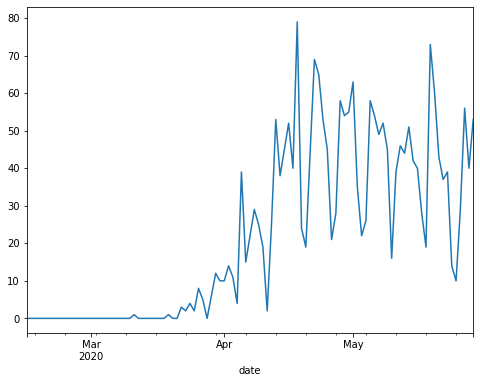

In [18]:
df.loc[idx['United States', 'California', 'Los Angeles'], 'new_deaths'].plot(figsize=(8, 6))

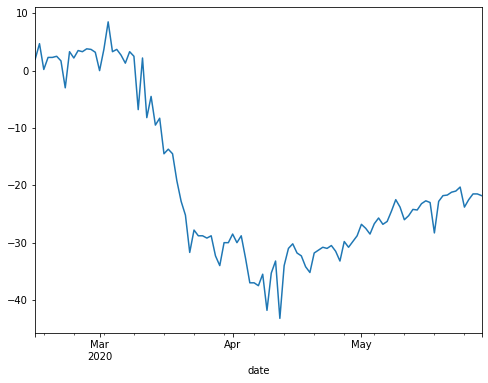

In [19]:
df.loc[idx['United States', 'California', 'Los Angeles'], 'mobility'].plot(figsize=(8, 6))